## Inicialización

In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Configuración de visualizaciones
sns.set(style="whitegrid")

## Cargar datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/`
- La carpeta `final_files` con 7600 fotos
- El archivo `labels.csv` con leyendas, con dos columnas: `file_name` y `real_age`

Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [2]:
# Cargar el archivo de etiquetas
labels = pd.read_csv('/datasets/faces/labels.csv')

# Tamaño del conjunto de datos
print(f"Tamaño del conjunto de datos: {labels.shape}")

# Primeras filas para explorar la estructura del archivo CSV
print("\nPrimeras filas del archivo de etiquetas:")
print(labels.head())

# Validar archivos en la carpeta de imágenes
image_files = set(os.listdir('/datasets/faces/final_files/'))
missing_files = labels[~labels['file_name'].isin(image_files)]
print(f"\nArchivos listados en CSV pero no presentes en el directorio: {len(missing_files)}")

if not missing_files.empty:
    print("\nPrimeros archivos faltantes:")
    print(missing_files.head())

Tamaño del conjunto de datos: (7591, 2)

Primeras filas del archivo de etiquetas:
    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17

Archivos listados en CSV pero no presentes en el directorio: 0


## EDA

In [3]:
# Identificación de duplicados y valores perdidos

# Identificación de duplicados
duplicated_rows = labels.duplicated(subset='file_name', keep=False)
print(f"\nNúmero de filas duplicadas: {duplicated_rows.sum()}")
if duplicated_rows.sum() > 0:
    print("Muestras duplicadas:")
    print(labels[duplicated_rows].head())

# Eliminación de duplicados
labels = labels.drop_duplicates(subset='file_name')
print(f"\nTamaño después de eliminar duplicados: {labels.shape}")

# Identificación de valores faltantes
missing_values = labels.isnull().sum()
print("\nValores perdidos por columna:")
print(missing_values)

if missing_values.any():
    print("\nFilas con valores perdidos:")
    print(labels[labels.isnull().any(axis=1)])

# Imputación de valores faltantes
labels['real_age'].fillna(labels['real_age'].median(), inplace=True)
print("\nTamaño después de imputar valores perdidos:", labels.shape)


Número de filas duplicadas: 0

Tamaño después de eliminar duplicados: (7591, 2)

Valores perdidos por columna:
file_name    0
real_age     0
dtype: int64

Tamaño después de imputar valores perdidos: (7591, 2)



Estadísticas descriptivas de la edad:
count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


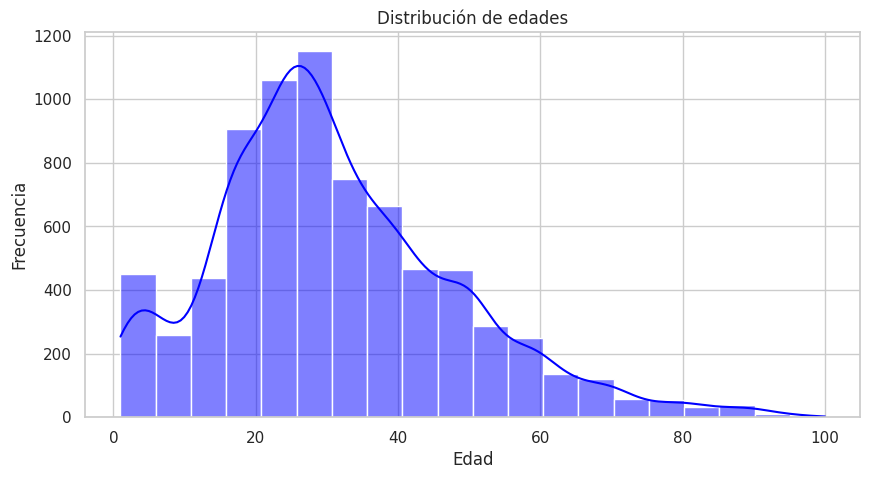


Valores atípicos:
Empty DataFrame
Columns: [file_name, real_age]
Index: []

Tamaño después de eliminar valores atípicos: (7591, 2)


In [4]:
# Distribución de la edad

# Estadísticas descriptivas
print("\nEstadísticas descriptivas de la edad:")
print(labels['real_age'].describe())

# Distribución de edades
plt.figure(figsize=(10, 5))
sns.histplot(labels['real_age'], kde=True, bins=20, color='blue')
plt.title('Distribución de edades')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

# Identificación de valores atípicos (p. ej., edades > 100)
outliers = labels[labels['real_age'] > 100]
print("\nValores atípicos:")
print(outliers)

# Eliminación de valores atípicos (opcional)
labels = labels[labels['real_age'] <= 100]
print(f"\nTamaño después de eliminar valores atípicos: {labels.shape}")


Muestras para edad 10:


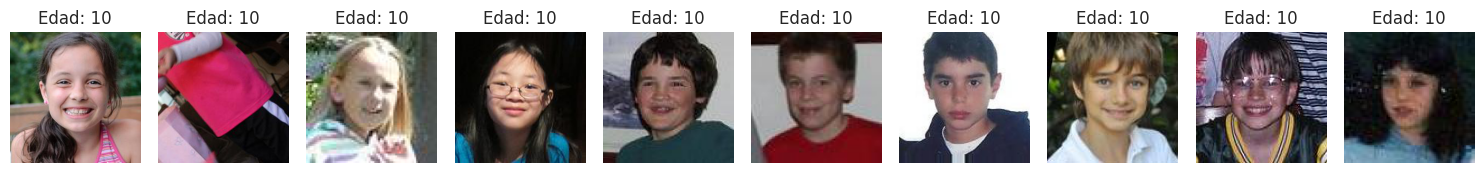


Muestras para edad 20:


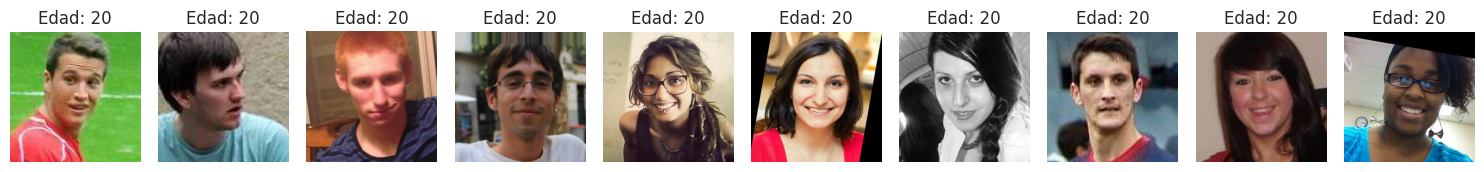


Muestras para edad 30:


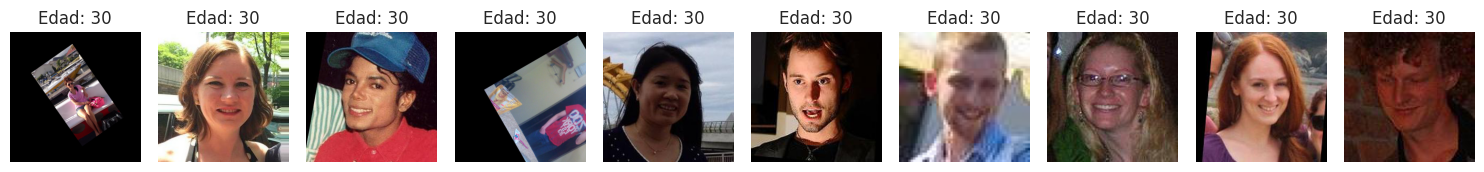


Muestras para edad 40:


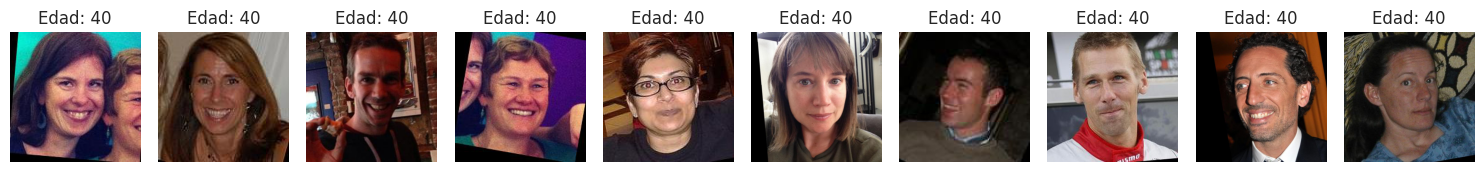


Muestras para edad 50:


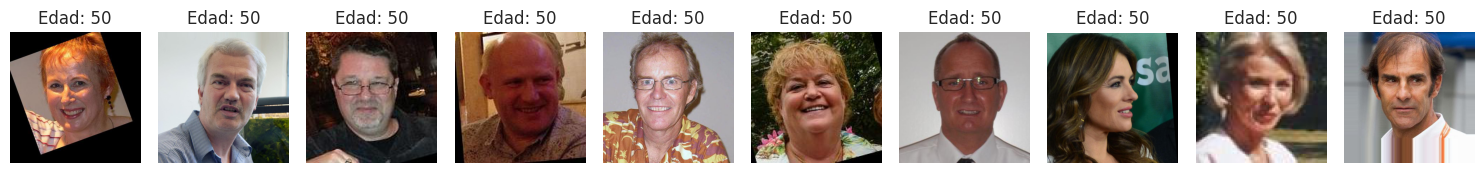

In [5]:
# Muestra de imágenes

# Función para mostrar imágenes por edad
def show_images_by_age(age, num_images=10):
    """Muestra imágenes de una edad específica."""
    files = labels[labels['real_age'] == age]['file_name'].head(num_images)
    fig, axes = plt.subplots(1, len(files), figsize=(15, 5))
    for ax, file in zip(axes, files):
        img_path = os.path.join('/datasets/faces/final_files/', file)
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Edad: {age}")
    plt.tight_layout()
    plt.show()

# Mostrar imágenes para edades específicas
for age in [10, 20, 30, 40, 50]:  # Cambia las edades según tu interés
    print(f"\nMuestras para edad {age}:")
    show_images_by_age(age)

### Conclusiones

Es posible observar que la edad puede oscilar de 1 hasta 100 años, siendo la mediana 29 y el promedio 31. Ante lo cual se puede afirmar que la edad de las personas de la base de datos analizada se concentran en los 29 años o menos. Finalmente, destaca que teniendo 7591 observaciones, no hubo valores perdidos.

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crear un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [6]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [7]:
def load_train(path):
    
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    
    datagen = ImageDataGenerator(
        validation_split=0.25,  # División entre entrenamiento y validación
        rescale=1/255.0        # Normalización de valores de píxeles
    )

    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',       # Salida continua (edad)
        subset='training',
        seed=12345
    )

    return train_gen_flow

In [8]:
def load_test(path):
    
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    """
    
    datagen = ImageDataGenerator(
        validation_split=0.25,  # División entre entrenamiento y validación
        rescale=1/255.0        # Normalización de valores de píxeles
    )

    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345
    )

    return test_gen_flow

In [9]:
def create_model(input_shape):
    
    """
    Define el modelo
    """
    
    base_model = ResNet50(
        weights='imagenet',  # Cargar pesos preentrenados en ImageNet
        include_top=False,   # Quitar la capa de clasificación final
        input_shape=input_shape
    )
    base_model.trainable = False  # Congelar capas preentrenadas

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),  # Reduce las dimensiones conservando características principales
        Dense(128, activation='relu'),
        Dropout(0.5),              # Regularización para evitar overfitting
        Dense(1, activation='linear')  # Salida continua (edad)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mean_squared_error',  # Métrica para regresión
        metrics=['mae']            # Error absoluto medio
    )

    return model

In [10]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo con los datos de entrenamiento y prueba.

    Parámetros:
    - model: El modelo creado con create_model().
    - train_data: Generador de datos para el conjunto de entrenamiento.
    - test_data: Generador de datos para el conjunto de validación.
    - batch_size: Tamaño del lote para entrenamiento (opcional si ya está configurado en el generador).
    - epochs: Número de épocas para entrenar.
    - steps_per_epoch: Número de pasos por época (opcional).
    - validation_steps: Número de pasos de validación por época (opcional).

    Retorna:
    - model: El modelo entrenado.
    """
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)

    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        batch_size=batch_size,
        verbose=2
    )
    return model

### Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [11]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    # Importaciones iniciales
    f.write(init_str)
    f.write('\n\n')
    
    # Definiciones de las funciones
    for fn_name in [load_train, load_test, create_model, train_model]:
        src = inspect.getsource(fn_name)  # Obtiene el código fuente de cada función
        f.write(src)  # Lo escribe en el archivo
        f.write('\n\n')

### Resultado

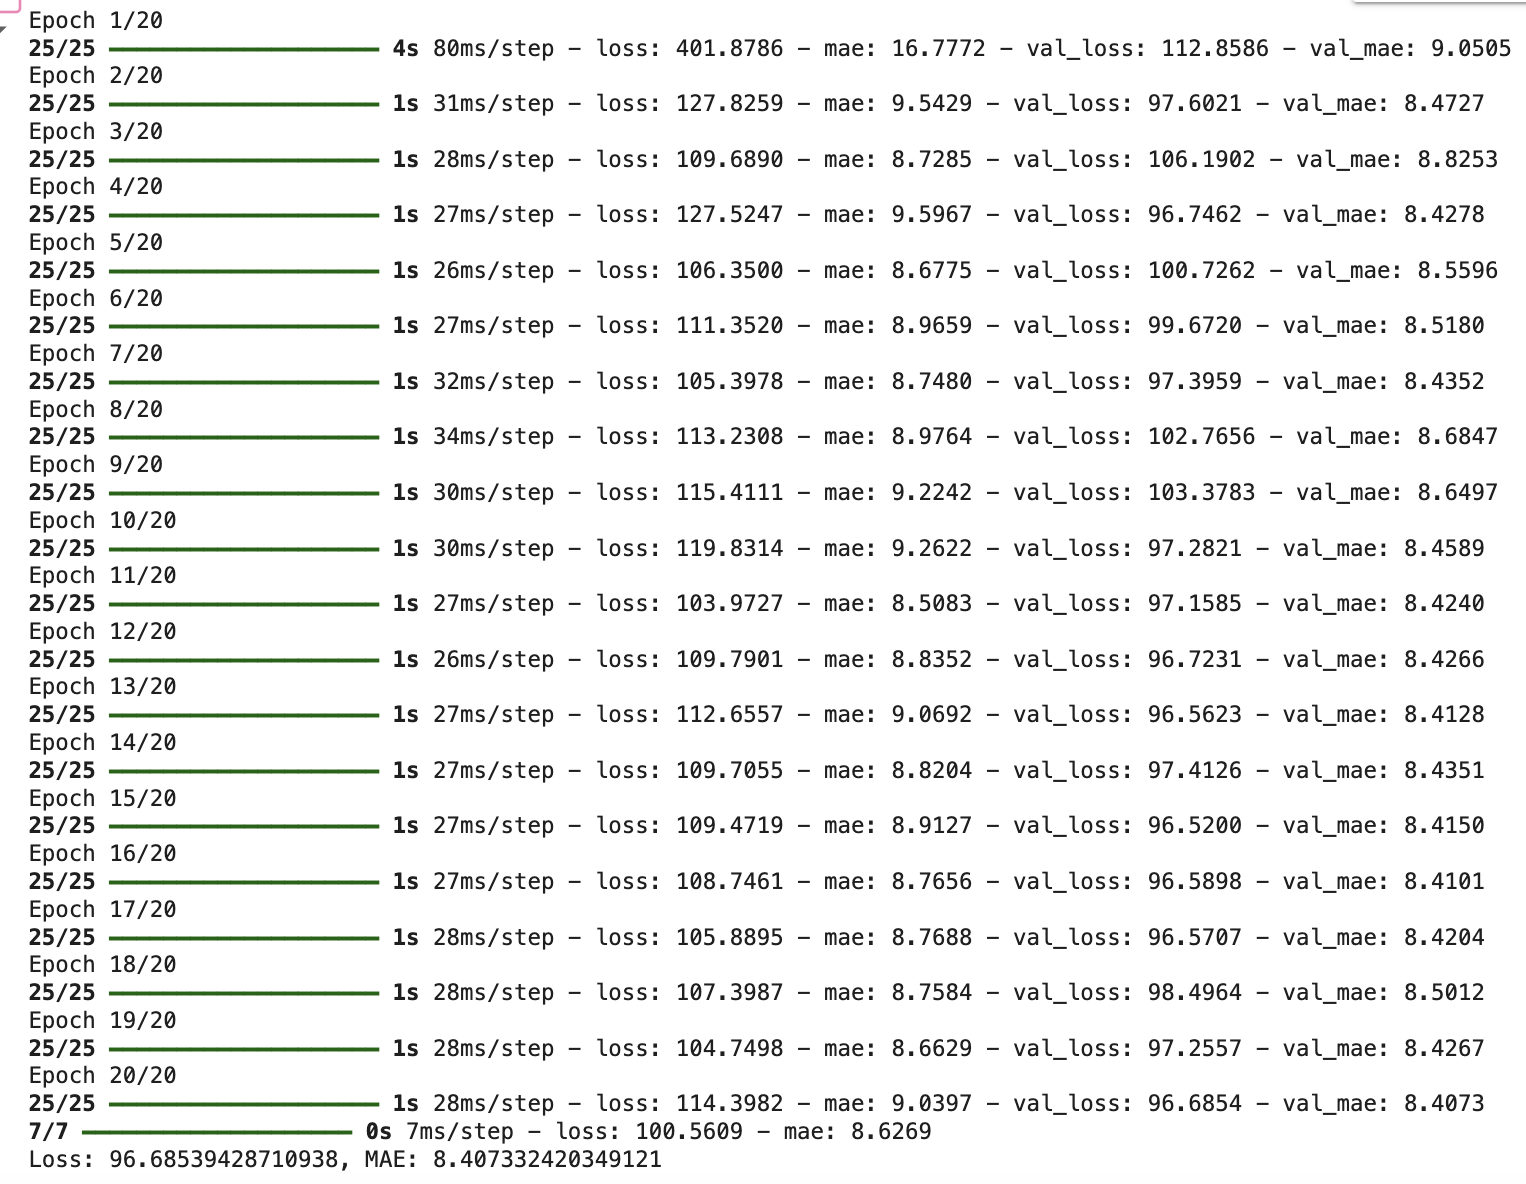

## Conclusiones

En primer lugar, es posible observar una mejora del modelo (MAE de 19.5.a 8.4), siendo este un buen indicativo de que el modelo tiene un desempeño adecuado. Adicionalmente, se puede observar que el MAE se estabiliza después de varias épocas de entrenamiento, demostrando ello que el modelo aprende lo suficiente de los datos

# Lista de revisión

- [x]  El Notebook estaba abierto 
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución
- [x]  Se realizó el análisis exploratorio de datos
- [x]  Los resultados del análisis exploratorio de datos se presentan en el notebook final
- [x]  El valor EAM del modelo no es superior a 8
- [x]  El código de entrenamiento del modelo se copió en el notebook final
- [x]  El resultado de entrenamiento del modelo se copió en el notebook final
- [x]  Los hallazgos se proporcionaron con base en los resultados del entrenamiento del modelo